### Train & Valid set Preparation

No of patients : 47 (48 records)

each person has 30 min (1800sec) ECG signals

splitted each signal into train : valid using 25 min :5 min of each person signal.

In the training set ,generated 150 samples for each person using non-overlapping window (window size 10sec)

In validation set ,generated 30 samples for each person uning no -ovelapping window

For each sample added a random distortion

Did min max scalling  and lable encoding

In [290]:
import wfdb
import numpy as np
import random
import os
import pywt
from sklearn.model_selection import train_test_split
import numpy as np


def load_lead_ii(record_path):
    record = wfdb.rdrecord(record_path)
    lead_ii = record.p_signal[:, 0]
    return lead_ii

def add_random_distortion(ecg_signal, fs=360):
    t = np.linspace(0, len(ecg_signal)/fs, len(ecg_signal), endpoint=False)
    
    def add_powerline_interference(signal):
        power_line_frequency = 60
        pli_amplitude = np.random.uniform(0.05, 0.15) * np.max(signal)
        pli_signal = pli_amplitude * np.sin(2 * np.pi * power_line_frequency * t)
        return signal + pli_signal

    def add_baseline_wander(signal):
        baseline_wander_frequency = np.random.uniform(0.1, 2)
        baseline_wander_amplitude = np.random.uniform(0.02, 0.07) * np.max(signal)
        baseline_wander = baseline_wander_amplitude * np.sin(2 * np.pi * baseline_wander_frequency * t)
        return signal + baseline_wander

    def add_gaussian_noise(signal):
        noise_amplitude = np.random.uniform(0.005, 0.02) * np.max(signal)
        noise = noise_amplitude * np.random.normal(size=len(signal))
        return signal + noise

    def add_random_spikes(signal):
        num_spikes = np.random.randint(5, 20)
        spike_amplitude = np.random.uniform(0.1, 0.3) * np.max(signal)
        spike_indices = np.random.choice(len(signal), num_spikes, replace=False)
        signal_with_spikes = np.copy(signal)
        for index in spike_indices:
            spike = spike_amplitude * (np.random.choice([-1, 1]))
            signal_with_spikes[index] += spike
        return signal_with_spikes

    def corrupt_wavelet_coefficients(signal):
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        level_to_corrupt = np.random.choice(range(1, 3))
        corruption_strength = np.random.uniform(0.05, 0.2)
        coeffs[level_to_corrupt] += corruption_strength * np.random.randn(*coeffs[level_to_corrupt].shape)
        corrupted_signal = pywt.waverec(coeffs, 'db4')
        return corrupted_signal[:len(signal)]

    distortions = [
        add_powerline_interference, 
        add_baseline_wander, 
        add_gaussian_noise, 
        add_random_spikes,
#         corrupt_wavelet_coefficients
    ]
    
    chosen_distortion = random.choice(distortions)
    distorted_signal = chosen_distortion(ecg_signal)
    
    
    return distorted_signal

def extract_10sec_windows(lead_ii, num_samples=180, window_size=360*10):
    windows = []
    total_length = len(lead_ii)
    max_windows = total_length // window_size
    num_samples=max_windows

#     if max_windows < num_samples:
#         num_samples=max_windows
# #         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)

def scale_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    
    for record in os.listdir(data_directory):
        if record.endswith('.dat'):
            record_name = os.path.splitext(record)[0]
            record_path = os.path.join(data_directory, record_name)
            
            lead_ii = load_lead_ii(record_path)
            
            total_duration = len(lead_ii) // 360
            if total_duration < 30:
                raise ValueError(f"Record {record_name} is shorter than 30 minutes.")

            # Split into 25-min train and 5-min test
            train_segment = lead_ii[:25*360*60]
            test_segment = lead_ii[25*360*60:]
            
            # Extract 1-minute windows from train segment
            train_windows = extract_10sec_windows(train_segment, num_samples)
            test_windows = extract_10sec_windows(test_segment, num_samples // 5)
            
            # Add distortions to both train and test segments
            distorted_train_windows = np.array([add_random_distortion(window) for window in train_windows])
            distorted_test_windows = np.array([add_random_distortion(window) for window in test_windows])
            
            # Scale the signals between 0 and 1
            scaled_train_windows = np.array([scale_signal(window) for window in distorted_train_windows])
            scaled_test_windows = np.array([scale_signal(window) for window in distorted_test_windows])
            
            # Store the data
            patient_data[record_name] = {
                'train': scaled_train_windows,
                'test': scaled_test_windows
            }
    
    return patient_data

# Example usage
data_directory = 'mit-bih-arrhythmia-database-1.0.0'
patient_data = process_mit_bih_data(data_directory)
import numpy as np
import os

def flatten_patient_data(patient_data):
    X_train = []
    X_test = []
    y_train = []
    y_test = []

    for record_name, data in patient_data.items():
        train_windows = data['train']
        test_windows = data['test']

        # Flatten the training and testing windows
        X_train.extend(train_windows)
        X_test.extend(test_windows)
        
        # Create labels
        num_train_samples = len(train_windows)
        num_test_samples = len(test_windows)

        y_train.extend([record_name] * num_train_samples)
        y_test.extend([record_name] * num_test_samples)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    return X_train, X_test, y_train, y_test

# Example usage
X_train, X_test, y_train, y_test = flatten_patient_data(patient_data)


# Reshape X_train and X_test to match the input shape expected by the CNN (samples, length of ECG signal, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Encode labels to integers
unique_labels = np.unique(y_train)
label_map = {label: index for index, label in enumerate(unique_labels)}
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

num_classes = len(unique_labels)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (7200, 3600, 1)
X_test shape: (1440, 3600, 1)
y_train shape: (7200,)
y_test shape: (1440,)


### Model Archeitecture

In [129]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_CNN_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=7, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(256, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(512, kernel_size=3, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(512, activation=None),  # Embedding layer
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # Normalize the embeddings
    ])
    return model

input_shape = (X_train.shape[1], 1)
cnn_model = create_CNN_model(input_shape)


In [130]:

from tensorflow.keras import backend as K

# Contrastive Loss Function
def contrastive_loss(y_true, y_pred, margin=2.0):
    # Ensure y_true is float32 to match y_pred's type
    y_true = tf.cast(y_true, y_pred.dtype)
    
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [131]:
from tensorflow.keras import backend as K

def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Create the Siamese network
def create_siamese_network(input_shape):
    input_A = layers.Input(shape=input_shape)
    input_B = layers.Input(shape=input_shape)
    
    # Pass both inputs through the FaceNet model
    embeddings_A = cnn_model(input_A)
    embeddings_B = cnn_model(input_B)
    
    # Compute the Euclidean distance between the embeddings
    distance = layers.Lambda(euclidean_distance)([embeddings_A, embeddings_B])
    
    # The Siamese network will output the distance between the embeddings
    siamese_network = models.Model(inputs=[input_A, input_B], outputs=distance)
    return siamese_network

siamese_network = create_siamese_network(input_shape)
siamese_network.compile(loss=contrastive_loss, optimizer='adam')


In [132]:
def create_pairs(X, y):
    pairs = []
    labels = []
    num_classes = len(np.unique(y))
    indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    for idx1 in range(len(X)):
        # Select a random positive example
        idx2 = random.choice(indices[y[idx1]])
        pairs.append([X[idx1], X[idx2]])
        labels.append(1)
        
        # Select a random negative example
        neg_idx = np.random.choice(np.where(y != y[idx1])[0])
        pairs.append([X[idx1], X[neg_idx]])
        labels.append(0)
        
        if random.random() < 0.00001:  # 10% chance to plot
            plt.title("anchor")
            plt.plot(X[idx1].reshape(-1)[:])
            plt.show()
            
            plt.title("postive")
            plt.plot(X[idx2].reshape(-1)[:])
            plt.show()
            
            plt.title('negative')
            plt.plot(X[neg_idx].reshape(-1)[:])
            plt.show()



    
    return np.array(pairs), np.array(labels)

# Create pairs for training and testing
pairs_train, labels_train = create_pairs(X_train, y_train)
pairs_test, labels_test = create_pairs(X_test, y_test)
labels_train=labels_train.astype(int)
labels_test=labels_test.astype(int)

### Training 

In [133]:
# Train the Siamese network
history = siamese_network.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    batch_size=32,
    epochs=20
)

Epoch 1/20
450/450 [==============================] - 1335s 3s/step - loss: 0.7661 - val_loss: 0.6386
Epoch 2/20
450/450 [==============================] - 1162s 3s/step - loss: 0.5618 - val_loss: 0.4817
Epoch 3/20
450/450 [==============================] - 610s 1s/step - loss: 0.4298 - val_loss: 0.3839
Epoch 4/20
450/450 [==============================] - 255s 567ms/step - loss: 0.3770 - val_loss: 0.3522
Epoch 5/20
450/450 [==============================] - 228s 506ms/step - loss: 0.3315 - val_loss: 0.3012
Epoch 6/20
450/450 [==============================] - 235s 523ms/step - loss: 0.3037 - val_loss: 0.2798
Epoch 7/20
450/450 [==============================] - 221s 491ms/step - loss: 0.2906 - val_loss: 0.2835
Epoch 8/20
450/450 [==============================] - 222s 494ms/step - loss: 0.2829 - val_loss: 0.2750
Epoch 9/20
450/450 [==============================] - 221s 491ms/step - loss: 0.2736 - val_loss: 0.2747
Epoch 10/20
450/450 [==============================] - 243s 539ms/step 

In [134]:
cnn_model.save('final_margin_2.0_no_wavelet_corruption.h5')

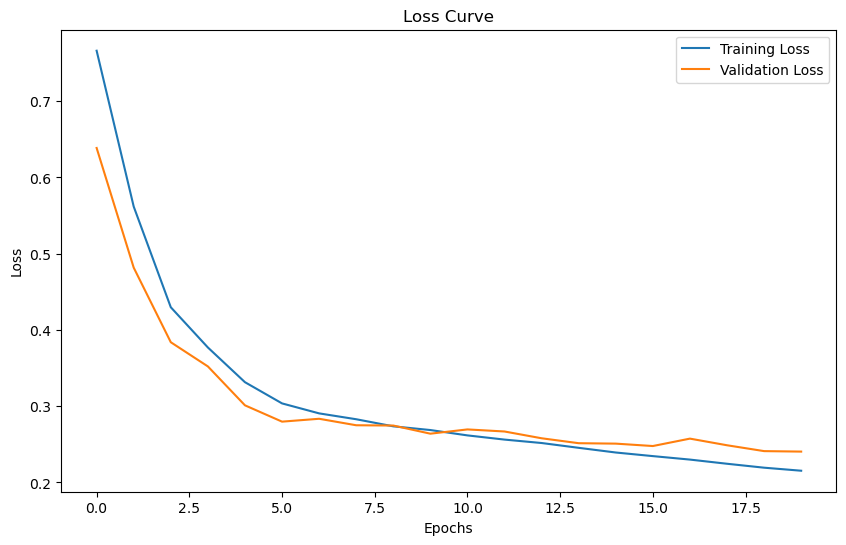

In [135]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history returned by the 'fit' method
def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss')

    # Plot validation loss
    plt.plot(history.history['val_loss'], label='Validation Loss')

    # Adding title and labels
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Call the function with your history object
plot_loss_curve(history)

In [136]:
# Step 2: Implement a custom kNN algorithm
def custom_knn(embeddings_train, labels_train, embeddings_test, k=5):
    predictions = []
    
    for test_embedding in embeddings_test:
        # Calculate the Euclidean distance between the test embedding and all train embeddings
        distances = np.linalg.norm(embeddings_train - test_embedding, axis=1)
        
        # Get the indices of the k-nearest neighbors
        knn_indices = np.argsort(distances)[:k]
        
        # Get the labels of the k-nearest neighbors
        knn_labels = labels_train[knn_indices]
        
        # Determine the most common label among the k-nearest neighbors
        unique_labels, counts = np.unique(knn_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        
        predictions.append(predicted_label)
    
    return np.array(predictions)


### Person idenitification on train set embeddings uing KNN

In [291]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import tensorflow as tf
cnn_model = tf.keras.models.load_model('final_non_overlapping.h5',compile=False)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X):
    embeddings = model.predict(X)
    return embeddings

# Generate embeddings for the test set
embeddings_test = generate_embeddings(cnn_model, X_test)


# Generate embeddings for the train set
embeddings_train = generate_embeddings(cnn_model, X_train)

 # Use the custom kNN algorithm to predict the class of each test embedding
predicted_labels = custom_knn(embeddings_train, y_train, embeddings_test, k=5)

 # Calculate precision, recall, and confusion matrix
precision = precision_score(y_test, predicted_labels, average='macro')
recall = recall_score(y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(y_test, predicted_labels)

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Confusion Matrix:\n", conf_matrix)


225/225 [==============================] - 13s 58ms/step
Precision: 97.72%
Recall: 97.64%
Confusion Matrix:
 [[29  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ... 30  0  0]
 [ 0  0  0 ...  0 30  0]
 [ 0  0  0 ...  0  0 30]]


Silhouette Score: 0.6525810956954956


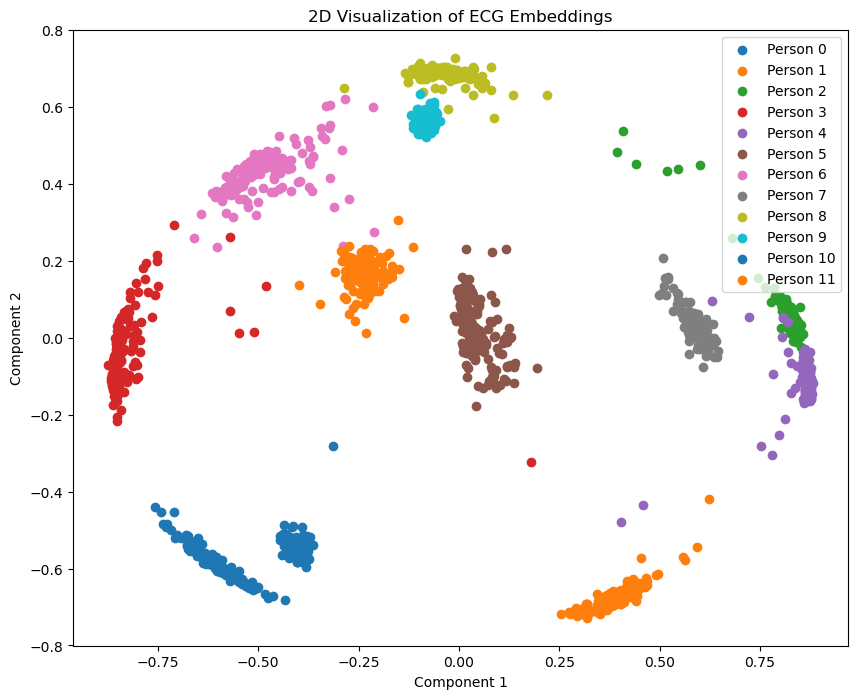

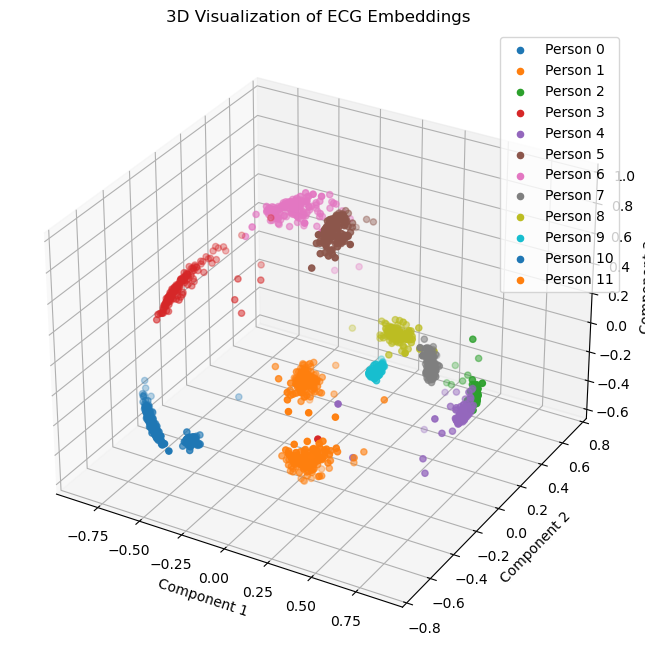

In [292]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the saved embedding model
# embedding_model = arcface_facenet_model
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(embeddings_train, y_train)
print(f"Silhouette Score: {silhouette_avg}")
# Generate embeddings for the test set
X_test_embeddings = embeddings_train[:1800]
y_test_embedding=y_train[:1800]


# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test_embedding):
        indices = np.where(y_test_embedding == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test_embedding):
        indices = np.where(y_test_embedding == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


## Person Identification using validation Set

In [302]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X):
    embeddings = model.predict(X)
    return embeddings
X_vec, X_cls, y_vec, y_cls = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)
print("training datat for KNN",X_vec.shape)
print("validation data for KNN",X_cls.shape)
print("no of pereson",y_cls.shape)
# Generate embeddings for the train set
embeddings_vec = generate_embeddings(cnn_model, X_vec)


# Generate embeddings for the test set
embeddings_cls = generate_embeddings(cnn_model, X_cls)




 # Use the custom kNN algorithm to predict the class of each test embedding
predicted_labels = custom_knn(embeddings_vec, y_vec, embeddings_cls, k=5)

 # Calculate precision, recall, and confusion matrix
precision = precision_score(y_cls, predicted_labels, average='macro')
recall = recall_score(y_cls, predicted_labels, average='macro')
conf_matrix = confusion_matrix(y_cls, predicted_labels)



f1_score_=f1_score(y_cls, predicted_labels, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score:" + str(f1_score_ ))

print("Confusion Matrix:\n", conf_matrix)


training datat for KNN (1152, 3600, 1)
validation data for KNN (288, 3600, 1)
no of pereson (288,)
9/9 [==============================] - 1s 55ms/step
Precision: 99.48%
Recall: 99.31%
F1 Score:0.9928571428571429
Confusion Matrix:
 [[6 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 6]]


Silhouette Score: 0.6503238677978516


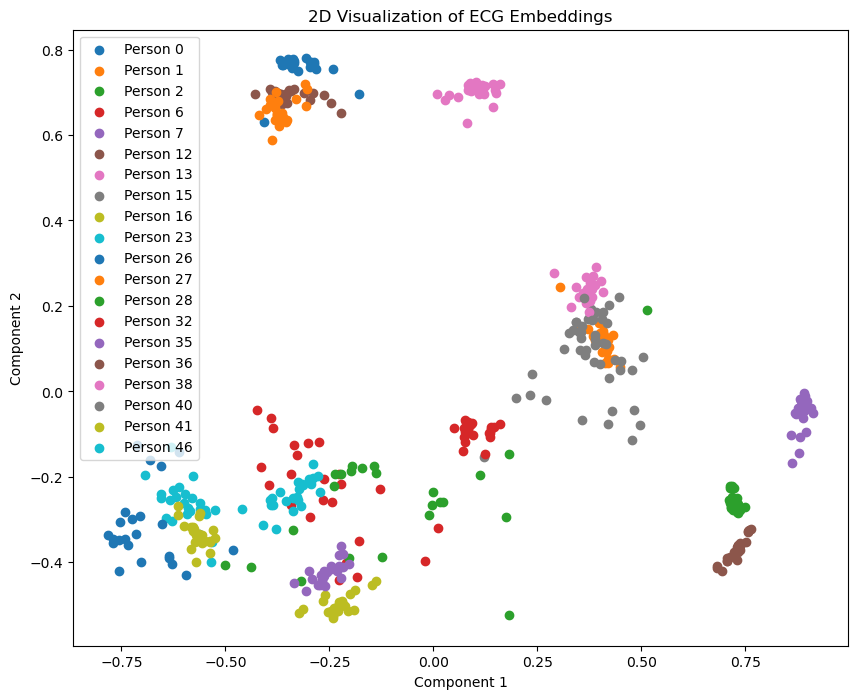

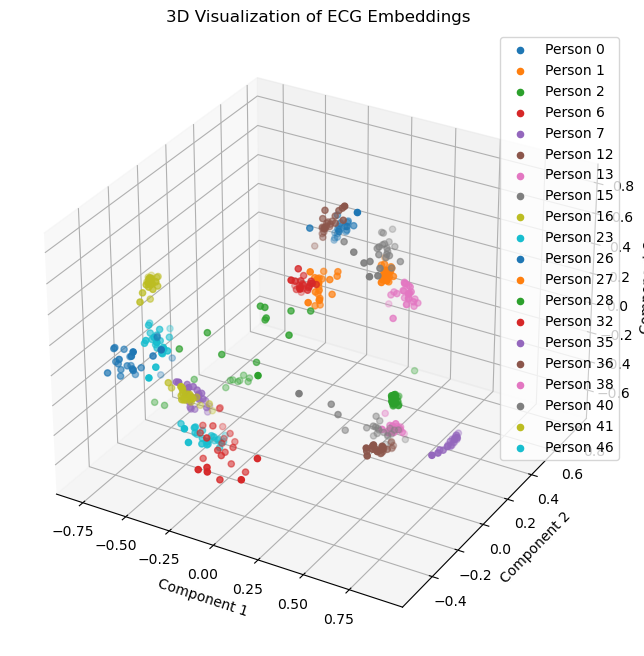

In [296]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


silhouette_avg = silhouette_score(embeddings_vec, y_vec)
print(f"Silhouette Score: {silhouette_avg}")
# Load the saved embedding model
# embedding_model = arcface_facenet_model
unique_classes = np.random.choice(np.unique(y_vec), 20, replace=False)

# Create a mask to select only those embeddings and labels corresponding to the 5 unique classes
mask = np.isin(y_vec, unique_classes)

# Filter the embeddings and labels
filtered_embeddings_train = embeddings_vec[mask]
filtered_ptb_y_train = y_vec[mask]
# Generate embeddings for the test set
X_test_embeddings = filtered_embeddings_train[:1800]
y_test_embedding=filtered_ptb_y_train[:1800]


from sklearn.metrics import silhouette_score

# Assume `embeddings` is the output from your model and `labels` are the true labels



# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test_embedding):
        indices = np.where(y_test_embedding == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test_embedding):
        indices = np.where(y_test_embedding == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


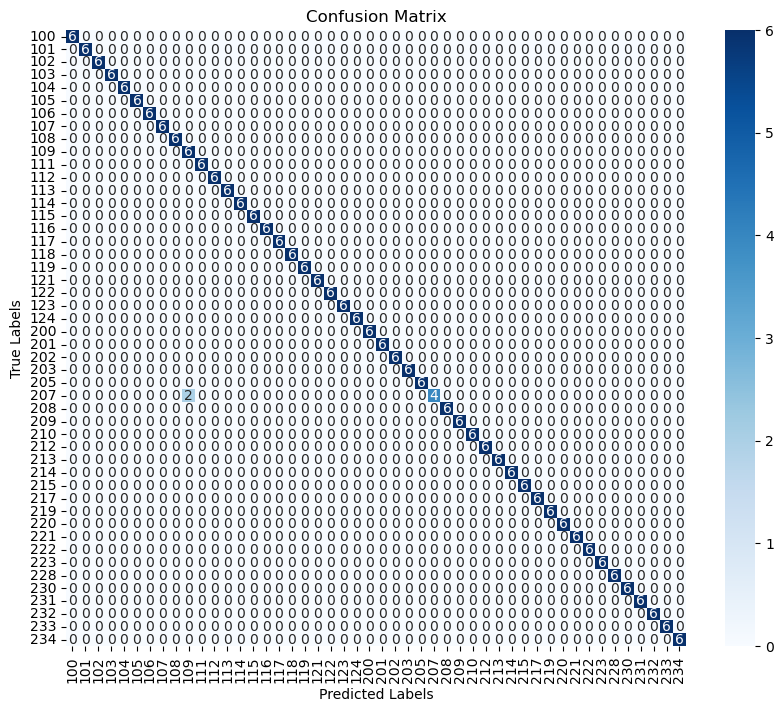

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_cls, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


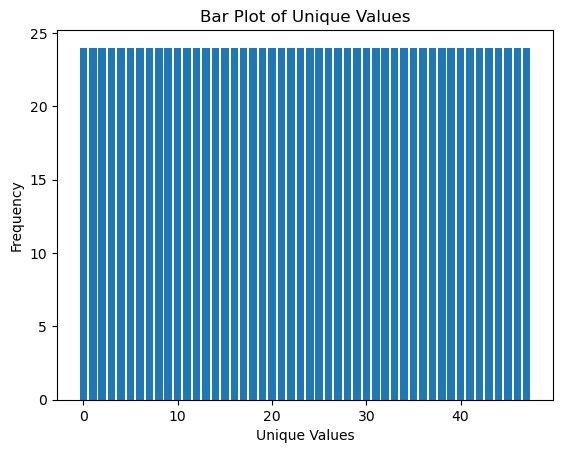

In [147]:
unique, frequency = np.unique(y_vec,
                              return_counts = True) 
print(unique)

plt.bar(unique, frequency)
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Bar Plot of Unique Values')
plt.show()

### Testing in PTB-XL

21799 clinical 12-lead ECGs from 18869 patients of 10 second length

In [286]:
import pandas as pd
import wfdb
import numpy as np
import random
from scipy.signal import resample

patient_ecg_data=pd.read_csv('datasets/ptbxl/exams.csv')
def load_ecg_data(file_path):
    record = wfdb.rdrecord(file_path)
    ecg_data = record.p_signal  # Extract the ECG signal
    header = wfdb.rdheader(file_path)
    print(header.sig_name)
    return ecg_data

In [287]:
patient_id_counts = patient_ecg_data['patient_id'].value_counts()

# Filter out the patient_ids that have less than 8 occurrences
valid_patient_ids = patient_id_counts[patient_id_counts>=5].index

# Filter the DataFrame to keep only rows with patient_ids that occur 8 or more times
df_filtered = patient_ecg_data[patient_ecg_data['patient_id'].isin(valid_patient_ids)][:1000]

# Reset the index if needed
patient_ecg_data = df_filtered.reset_index(drop=True)

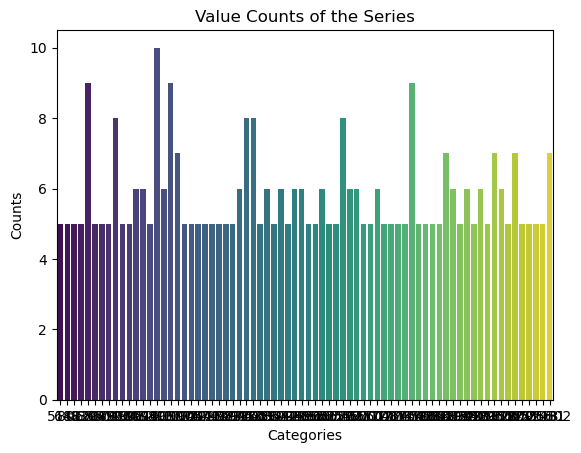

In [275]:
patient_id_counts = patient_ecg_data['patient_id'].value_counts()
sns.barplot(x=patient_id_counts.index, y=patient_id_counts.values, palette='viridis')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Value Counts of the Series')
plt.show()

In [266]:
patient_ecg_data.shape

(415, 28)

In [276]:
def load_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead
    return lead_ii

In [277]:
ecg_data_list = []

labels = []
# "C:\Users\User\Documents\SEM 5\DS_project\Codebase\electrocadiogaurdImplementation\datasets\ptbxl\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
# Iterate over the file paths and load ECG data
for i in range((int(len(patient_ecg_data)))):
    patient_id = patient_ecg_data.iloc[i]['patient_id']
    path = patient_ecg_data.iloc[i]['filename_lr']
    full_path = f'datasets\ptbxl\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/{path}'  # Adjust the path based on where the files are located
    ecg_data = load_lead_ii(full_path)
#     for i in range(10):
#     distorted_signal=add_random_distortion(ecg_data)
#         distorted_signal=ecg_data

#     distorted_windows = np.array([add_random_distortion(window) for window in ecg_data])
    scaled_signal = scale_signal(ecg_data) 

    target_samples = 3600
    signal = resample(scaled_signal, target_samples)
    ecg_data_list.append(signal)
    labels.append(patient_id)
    # Append the processed ECG data and corresponding label
    # ecg_data_list.append(ecg_data)
    # labels.append(patient_id)

# Convert the list of ECG data to a NumPy array
ecg_data_list = np.array(ecg_data_list)
labels=np.array(labels).astype(int)

print(ecg_data_list.shape)  # This should show (number_of_samples, 12, 5000)


(415, 3600)


In [278]:
print(ecg_data_list.shape)  # This should show (number_of_samples, 12, 5000)


(415, 3600)


In [279]:
labels.shape

(415,)

In [280]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# oversample = SMOTE()
# ecg_data_list, labels = ADASYN().fit_resample(ecg_data_list,labels)
ptbxl_X=ecg_data_list.reshape(-1, 3600, 1)
ptbxl_y=labels
ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)
# model = tf.keras.models.load_model('final_98.h5',compile=False)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train set
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)

# Generate embeddings for the test set
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)


print(embeddings_train.shape)

# Use the custom kNN algorithm to predict the class of each test embedding
predicted_labels = custom_knn(embeddings_train, ptb_y_train, embeddings_test, k=5)

# Calculate precision, recall, and confusion matrix
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Confusion Matrix:\n", conf_matrix)


3/3 [==============================] - 0s 51ms/step
(332, 512)
Precision: 35.05%
Recall: 43.15%
Confusion Matrix:
 [[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [288]:
ecg_data_list = []

labels = []
# "C:\Users\User\Documents\SEM 5\DS_project\Codebase\electrocadiogaurdImplementation\datasets\ptbxl\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
# Iterate over the file paths and load ECG data
for i in range((int(len(patient_ecg_data)))):
    patient_id = patient_ecg_data.iloc[i]['patient_id']
    path = patient_ecg_data.iloc[i]['filename_lr']
    full_path = f'datasets\ptbxl\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/{path}'  # Adjust the path based on where the files are located
    ecg_data = load_lead_ii(full_path)
    for i in range(18):
        distorted_signal=add_random_distortion(ecg_data)
#         distorted_signal=ecg_data

#     distorted_windows = np.array([add_random_distortion(window) for window in ecg_data])
        scaled_signal = scale_signal(distorted_signal) 

        target_samples = 3600
        signal = resample(scaled_signal, target_samples)
        ecg_data_list.append(signal)
        labels.append(patient_id)
        # Append the processed ECG data and corresponding label
        # ecg_data_list.append(ecg_data)
        # labels.append(patient_id)

# Convert the list of ECG data to a NumPy array
ecg_data_list = np.array(ecg_data_list)
labels=np.array(labels).astype(int)

print(ecg_data_list.shape)  # This should show (number_of_samples, 12, 5000)


(7470, 3600)


In [289]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# oversample = SMOTE()
# ecg_data_list, labels = ADASYN().fit_resample(ecg_data_list,labels)
ptbxl_X=ecg_data_list.reshape(-1, 3600, 1)
ptbxl_y=labels
ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)
# model = tf.keras.models.load_model('final_98.h5',compile=False)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train set
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)

# Generate embeddings for the test set
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)


print(embeddings_train.shape)

# Use the custom kNN algorithm to predict the class of each test embedding
predicted_labels = custom_knn(embeddings_train, ptb_y_train, embeddings_test, k=5)

# Calculate precision, recall, and confusion matrix
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Confusion Matrix:\n", conf_matrix)


47/47 [==============================] - 3s 60ms/step
(5976, 512)
Precision: 90.80%
Recall: 91.03%
Confusion Matrix:
 [[16  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  0]
 ...
 [ 0  0  0 ... 17  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0 17]]


In [261]:
len(np.unique(ptb_y_train))

961

Silhouette Score: -0.008128548040986061


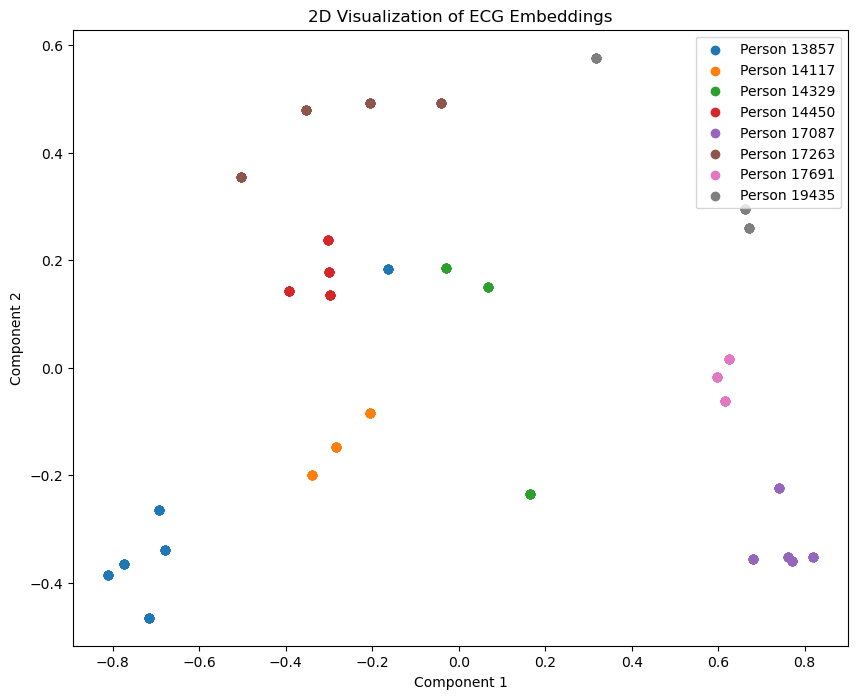

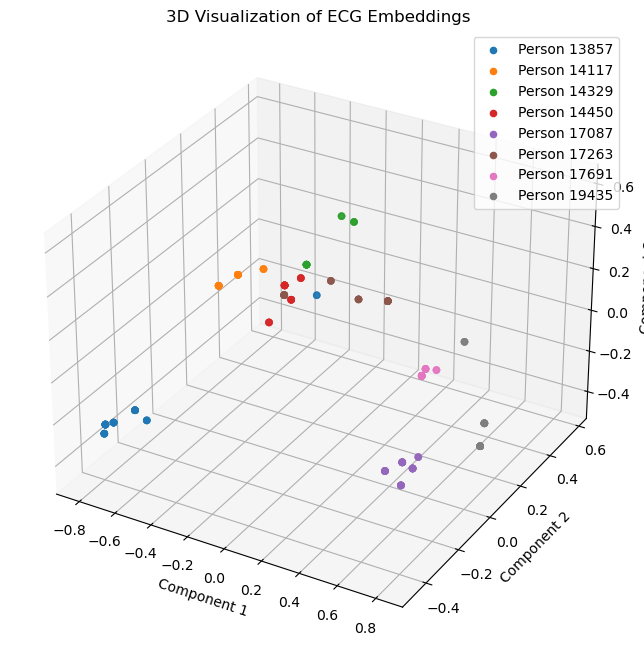

In [75]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Assume `embeddings` is the output from your model and `labels` are the true labels
silhouette_avg = silhouette_score(embeddings_train, ptb_y_train)
print(f"Silhouette Score: {silhouette_avg}")

# Load the saved embedding model
# embedding_model = arcface_facenet_model
unique_classes = np.random.choice(np.unique(ptb_y_train), 8, replace=False)

# Create a mask to select only those embeddings and labels corresponding to the 5 unique classes
mask = np.isin(ptb_y_train, unique_classes)

# Filter the embeddings and labels
filtered_embeddings_train = embeddings_train[mask]
filtered_ptb_y_train = ptb_y_train[mask]
# Generate embeddings for the test set
X_test_embeddings = filtered_embeddings_train
y_test=filtered_ptb_y_train
# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test):
        indices = np.where(y_test == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test):
        indices = np.where(y_test == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


# st-petersburg-incart-12-lead-arrhythmia-database-1.0.0

75 patients
fs: 257 length: 1800.0 s
fs: 257 length: 1800.0 s
fs: 257 length: 1800.0 s


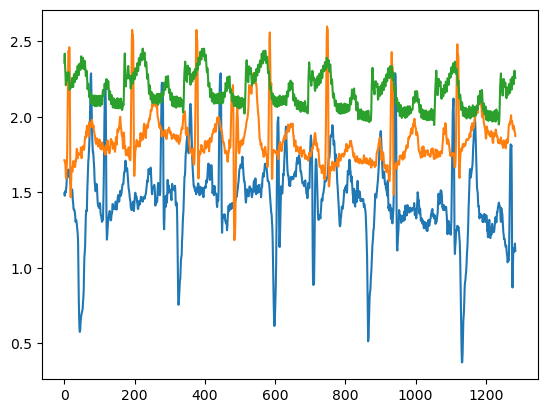

In [346]:
def load_a_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
    
    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]
    fs=wfdb.rdheader(record_path).fs
    print('fs:',fs,'length:',(len(lead_ii))/fs,'s', )
    plt.plot(lead_ii[:fs*5])
    
    
#     print(wfdb.rdheader(record_path).fs)
    return lead_ii
data_directory='files'
print('75','patients')
for record in os.listdir(data_directory)[:10]:
    if record.endswith('.dat'):
        load_a_lead_ii('files/'+os.path.splitext(record)[0])

In [337]:
import wfdb
import numpy as np
import random
import os
import pywt
def load_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead
    return lead_ii


import numpy as np

def extract_1_minute_windows(lead_ii, num_samples=180, window_size=257*10):
    windows = []
    total_length = len(lead_ii)
    
    # Calculate the number of possible non-overlapping windows
    max_windows = total_length // window_size
    num_samples=num_samples
    
#     if max_windows < num_samples:
#         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    # Extract non-overlapping windows
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)


def scale_signal(signal):
    # Scale the signal between 0 and 1
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    
    for record in os.listdir(data_directory):
        if record.endswith('.dat'):
            record_name = os.path.splitext(record)[0]
            record_path = os.path.join(data_directory, record_name)
            
            # Load Lead II
            lead_ii = load_lead_ii(record_path)
            
            # Extract 1-minute windows
            windows = extract_1_minute_windows(lead_ii, num_samples)
            
            # Add distortions
#             distorted_windows = np.array([add_random_distortion(window) for window in windows])
            
            # Scale the signals between 0 and 1
            scaled_windows = np.array([scale_signal(window) for window in windows])
            
            # Store the data
            patient_data[record_name] = scaled_windows
            
       
                
    return patient_data


# Example usage
data_directory = 'files'
patient_data = process_mit_bih_data(data_directory)

# Now patient_data contains 30 distorted and scaled 1-minute windows for each patient.


In [338]:
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import resample

# Assuming `patient_data` is a dictionary with patient IDs as keys and their corresponding 1-minute ECG windows as values.

# Convert the dictionary to lists for processing
X = []
y = []

for patient_id, windows in patient_data.items():
    for window in windows:
        
        window = resample(window, 3600)

        X.append(window)
        y.append(patient_id)

X = np.array(X)
y = np.array(y)

In [339]:
X.shape

(13500, 3600)

In [340]:
np.unique(y)

array(['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09',
       'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18',
       'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27',
       'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36',
       'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45',
       'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54',
       'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I61', 'I62', 'I63',
       'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72',
       'I73', 'I74', 'I75'], dtype='<U3')

In [341]:
print("no of patients ",len(np.unique(y)))

no of patients  75


['I01' 'I02' 'I03' 'I04' 'I05' 'I06' 'I07' 'I08' 'I09' 'I10' 'I11' 'I12'
 'I13' 'I14' 'I15' 'I16' 'I17' 'I18' 'I19' 'I20' 'I21' 'I22' 'I23' 'I24'
 'I25' 'I26' 'I27' 'I28' 'I29' 'I30' 'I31' 'I32' 'I33' 'I34' 'I35' 'I36'
 'I37' 'I38' 'I39' 'I40' 'I41' 'I42' 'I43' 'I44' 'I45' 'I46' 'I47' 'I48'
 'I49' 'I50' 'I51' 'I52' 'I53' 'I54' 'I55' 'I56' 'I57' 'I58' 'I59' 'I60'
 'I61' 'I62' 'I63' 'I64' 'I65' 'I66' 'I67' 'I68' 'I69' 'I70' 'I71' 'I72'
 'I73' 'I74' 'I75']


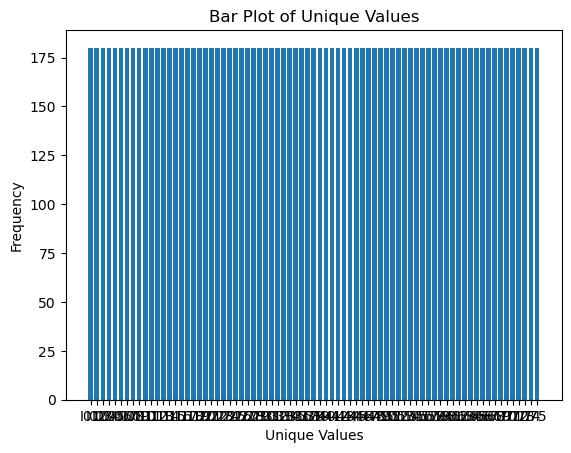

In [342]:
unique, frequency = np.unique(y,
                              return_counts = True) 
print(unique)

plt.bar(unique, frequency)
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Bar Plot of Unique Values')
plt.show()

In [345]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
# cnn_model = tf.keras.models.load_model('final_98.h5',compile=False)
# cnn_model = tf.keras.models.load_model('final_margin_2.0_no_wavelet_corruption.h5',compile=False)

cnn_model = tf.keras.models.load_model('final_non_overlapping.h5',compile=False)
# oversample = SMOTE()
# ecg_data_list, labels = ADASYN().fit_resample(ecg_data_list,labels)
ptbxl_X=X.reshape(-1, 3600, 1)
ptbxl_y=y
ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)
# model = tf.keras.models.load_model('final_98.h5',compile=False)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train set
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)

# Generate embeddings for the test set
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)


print(embeddings_train.shape)

# Use the custom kNN algorithm to predict the class of each test embedding
predicted_labels = custom_knn(embeddings_train, ptb_y_train, embeddings_test, k=5)

# Calculate precision, recall, and confusion matrix
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)
f1_score_=f1_score(ptb_y_test, predicted_labels, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score:" + str(f1_score_ ))
print("Confusion Matrix:\n", conf_matrix)


85/85 [==============================] - 5s 63ms/step
(10800, 512)
Precision: 86.60%
Recall: 86.48%
F1 Score:0.8602408542408488
Confusion Matrix:
 [[33  8  0 ...  0  0  0]
 [ 1 32  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0 35  6]
 [ 0  0  0 ...  0  0 45]]


In [344]:
np.unique(predicted_labels)

array(['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09',
       'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18',
       'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27',
       'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36',
       'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45',
       'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54',
       'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I61', 'I62', 'I63',
       'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72',
       'I73', 'I74', 'I75'], dtype='<U3')

In [351]:
print("KNN")
print("train set ",ptb_X_train.shape )
print("test set " ,ptb_X_test.shape)

KNN
train set  (10800, 3600, 1)
test set  (2700, 3600, 1)


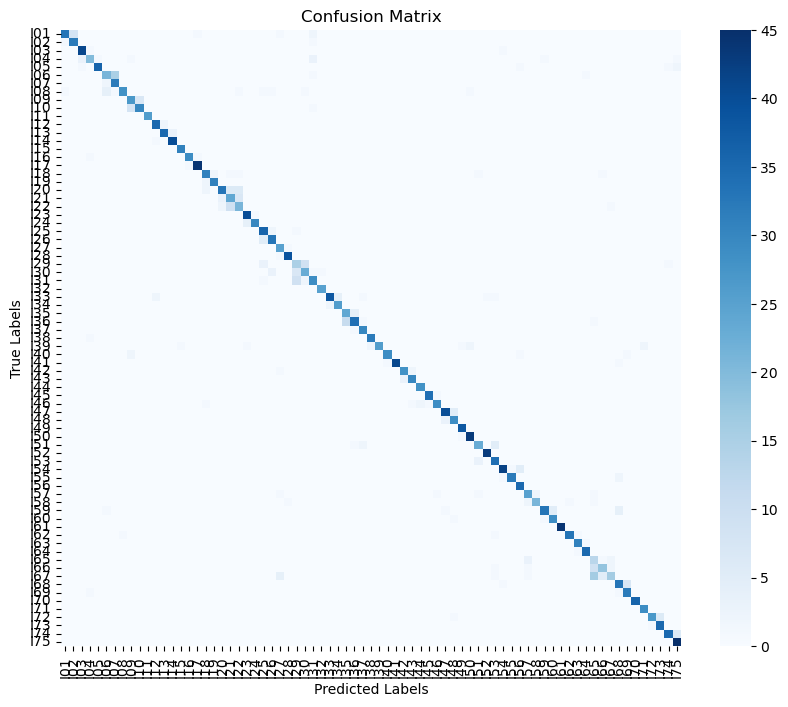

In [347]:

unique_labels = np.unique(ptb_y_test)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,  fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_cls, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Silhouette Score: 0.11572533845901489


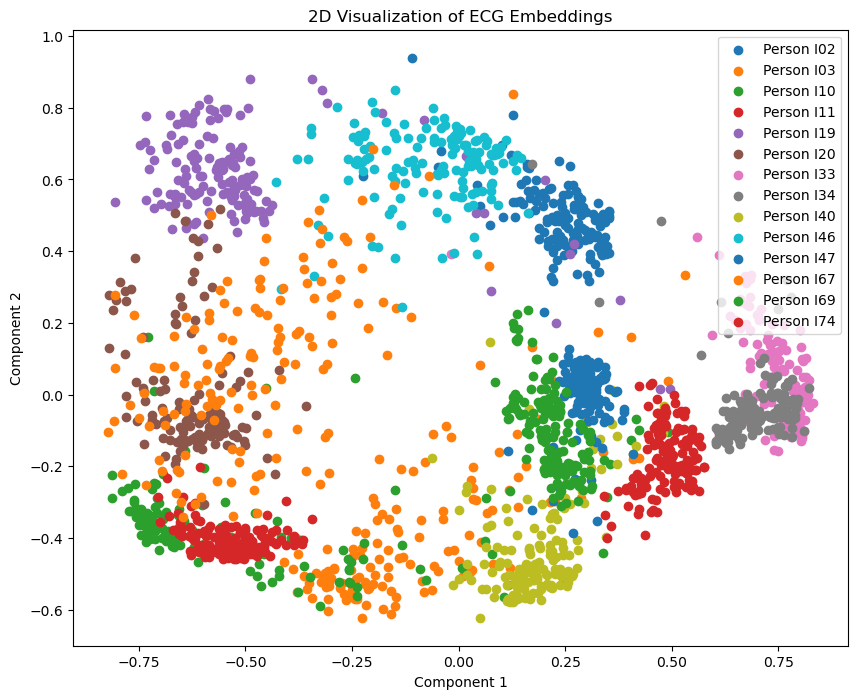

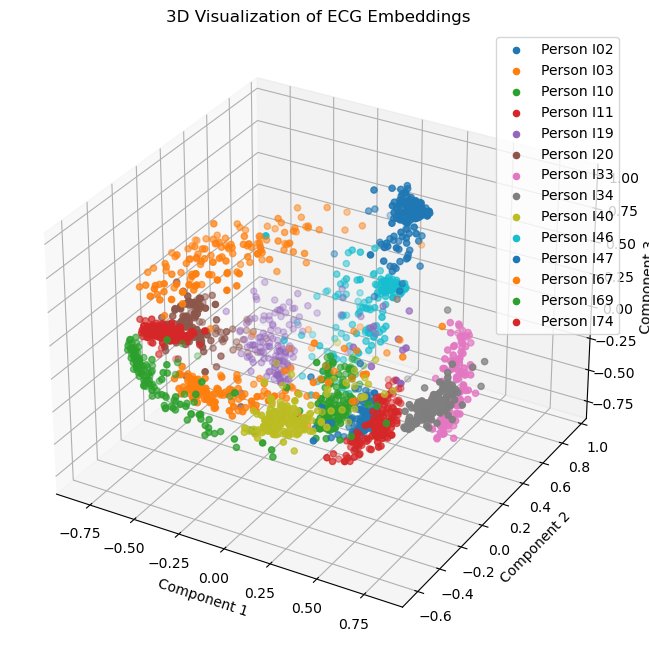

In [350]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Assume `embeddings` is the output from your model and `labels` are the true labels
silhouette_avg = silhouette_score(embeddings_train, ptb_y_train)
print(f"Silhouette Score: {silhouette_avg}")

# Load the saved embedding model
# embedding_model = arcface_facenet_model
unique_classes = np.random.choice(np.unique(ptb_y_train), 14, replace=False)

# Create a mask to select only those embeddings and labels corresponding to the 5 unique classes
mask = np.isin(ptb_y_train, unique_classes)

# Filter the embeddings and labels
filtered_embeddings_train = embeddings_train[mask]
filtered_ptb_y_train = ptb_y_train[mask]
# Generate embeddings for the test set
X_test_embeddings = filtered_embeddings_train
y_test=filtered_ptb_y_train
# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test):
        indices = np.where(y_test == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test):
        indices = np.where(y_test == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


Silhouette Score: 0.11572533845901489


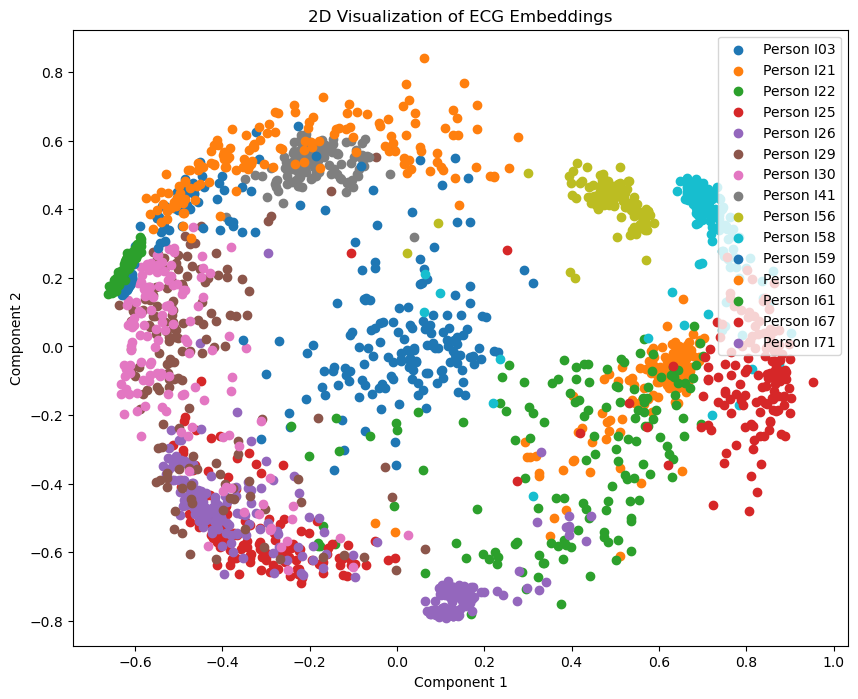

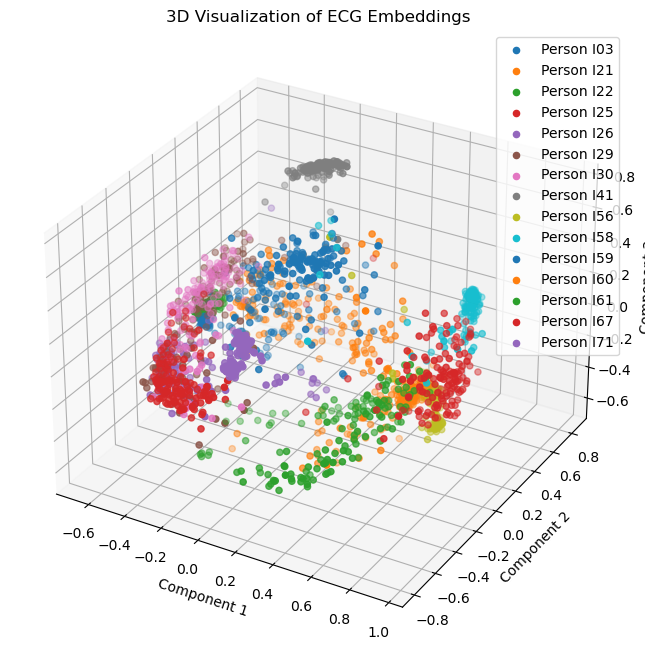

In [96]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Assume `embeddings` is the output from your model and `labels` are the true labels
silhouette_avg = silhouette_score(embeddings_train, ptb_y_train)
print(f"Silhouette Score: {silhouette_avg}")

# Load the saved embedding model
# embedding_model = arcface_facenet_model
unique_classes = np.random.choice(np.unique(ptb_y_train), 15, replace=False)

# Create a mask to select only those embeddings and labels corresponding to the 5 unique classes
mask = np.isin(ptb_y_train, unique_classes)

# Filter the embeddings and labels
filtered_embeddings_train = embeddings_train[mask]
filtered_ptb_y_train = ptb_y_train[mask]
# Generate embeddings for the test set
X_test_embeddings = filtered_embeddings_train
y_test=filtered_ptb_y_train
# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test):
        indices = np.where(y_test == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test):
        indices = np.where(y_test == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


# PTB Dataset

no of Patients 290
fs: 1000 length: 38.4 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.174 s
fs: 1000 length: 115.174 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.174 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 32.0 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s
fs: 1000 length: 115.2 s


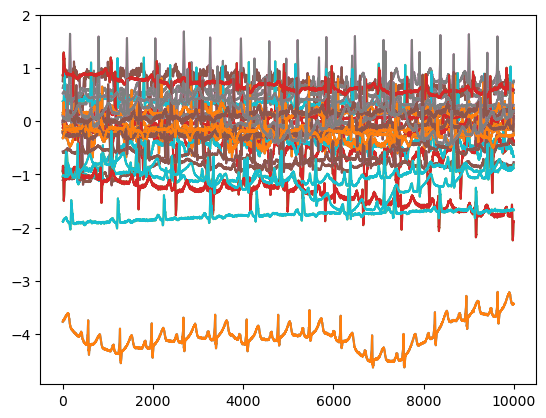

In [304]:
def load_a_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
    
    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]
    fs=wfdb.rdheader(record_path).fs
    fs=wfdb.rdheader(record_path).fs
    print('fs:',fs,'length:',(len(lead_ii))/fs,'s', )
    plt.plot(lead_ii[:fs*10])
    plt.plot(lead_ii[:fs*10])
    
    
#     print(wfdb.rdheader(record_path).fs)
    return lead_ii
data_directory='ptb-diagnostic-ecg-database-1.0.0'
print("no of Patients", len(os.listdir(data_directory)))

for patient in os.listdir(data_directory)[:10]:
        for record in os.listdir(data_directory+'/'+patient):
#             print(record)
            if record.endswith('.dat'):
                load_a_lead_ii('ptb-diagnostic-ecg-database-1.0.0/'+patient+'/'+os.path.splitext(record)[0])

In [322]:
import wfdb
import numpy as np
import random
import os
import pywt
def load_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
#     print(wfdb.rdheader(record_path).fs)
#     print(wfdb.rdheader(record_path).fs)

    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead
    return lead_ii



import numpy as np

def extract_1_minute_windows(lead_ii,fs):
    window_size=int(fs)*10
    windows = []
    total_length = len(lead_ii)
    
    # Calculate the number of possible non-overlapping windows
    max_windows = total_length // window_size
    num_samples=max_windows
    
#     if max_windows < num_samples:
#         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    # Extract non-overlapping windows
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)


def scale_signal(signal):
    # Scale the signal between 0 and 1
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    
    for patient in os.listdir(data_directory):
        patient_scalled_window=[]
        for record in os.listdir(data_directory+'/'+patient):
#             print(record)
            if record.endswith('.dat'):
                
                
                record_name = os.path.splitext(record)[0]
                record_path =data_directory+'/'+patient+'/'+record_name

                # Load Lead II
#                 lead_ii = load_lead_ii(record_path)
                record = wfdb.rdrecord(record_path)
#                 print(wfdb.rdheader(record_path).fs)
#                 print(wfdb.rdheader(record_path).sig_name)
                fs=wfdb.rdheader(record_path).fs
                # Extract Lead II (usually the second channel)
                lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead

                # Extract 1-minute windows
                windows = extract_1_minute_windows(lead_ii ,fs)

                # Add distortions
    #             distorted_windows = np.array([add_random_distortion(window) for window in windows])

                # Scale the signals between 0 and 1
                scaled_windows = np.array([scale_signal(window) for window in windows])
            
                patient_scalled_window.append(scaled_windows)
        
        # Concatenate all accumulated windows into a single array for each patient
        patient_data[patient] = np.concatenate(patient_scalled_window, axis=0)



    return patient_data


# Example usage
data_directory = 'ptb-diagnostic-ecg-database-1.0.0'
patient_data = process_mit_bih_data(data_directory)

# Now patient_data contains 30 distorted and scaled 1-minute windows for each patient.


In [306]:
load_lead_ii("ptb-diagnostic-ecg-database-1.0.0\patient034\s0118lre").shape

(115200,)

In [323]:
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import resample

# Assuming `patient_data` is a dictionary with patient IDs as keys and their corresponding 1-minute ECG windows as values.

# Convert the dictionary to lists for processing
X = []
y = []

for patient_id, windows in patient_data.items():
    for window in windows:
        
        window = resample(window, 3600)

        X.append(window)
        y.append(patient_id)

X = np.array(X)
y = np.array(y)

In [324]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
# cnn_model = tf.keras.models.load_model('final_margin_2.0_no_wavelet_corruption.h5',compile=False)

cnn_model = tf.keras.models.load_model('final_non_overlapping.h5',compile=False)
# cnn_model = tf.keras.models.load_model('final_98.h5',compile=False)

# oversample = SMOTE()
# ecg_data_list, labels = ADASYN().fit_resample(ecg_data_list,labels)
ptbxl_X=X.reshape(-1, 3600, 1)
ptbxl_y=y
ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train set
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)

# Generate embeddings for the test set
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)


print(embeddings_train.shape)

# Use the custom kNN algorithm to predict the class of each test embedding
predicted_labels = custom_knn(embeddings_train, ptb_y_train, embeddings_test, k=5)

# Calculate precision, recall, and confusion matrix
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)

# print("Precision: {:.2f}%".format(precision * 100))
# print("Recall: {:.2f}%".format(recall * 100))
f1_score_=f1_score(ptb_y_test, predicted_labels, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score:" + str(f1_score_ ))
print("Confusion Matrix:\n", conf_matrix)


36/36 [==============================] - 3s 69ms/step
(4579, 512)
Precision: 87.59%
Recall: 88.82%
F1 Score:0.8758230884486238
Confusion Matrix:
 [[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


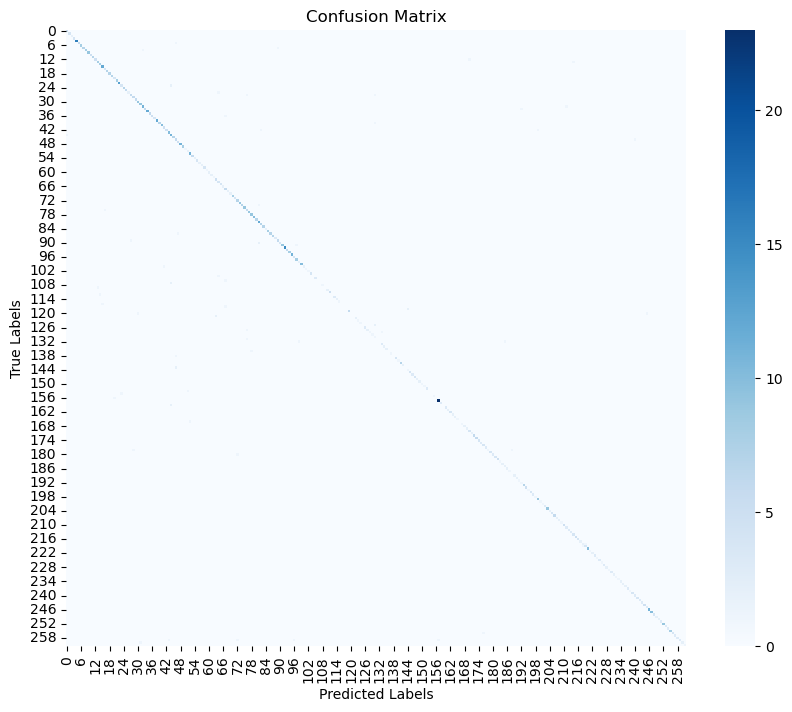

In [325]:
unique_labels = np.unique(ptb_y_test)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,  fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [316]:
len(unique_labels)
ptb_y_test.shape

(1145,)

Silhouette Score: 0.3816780149936676


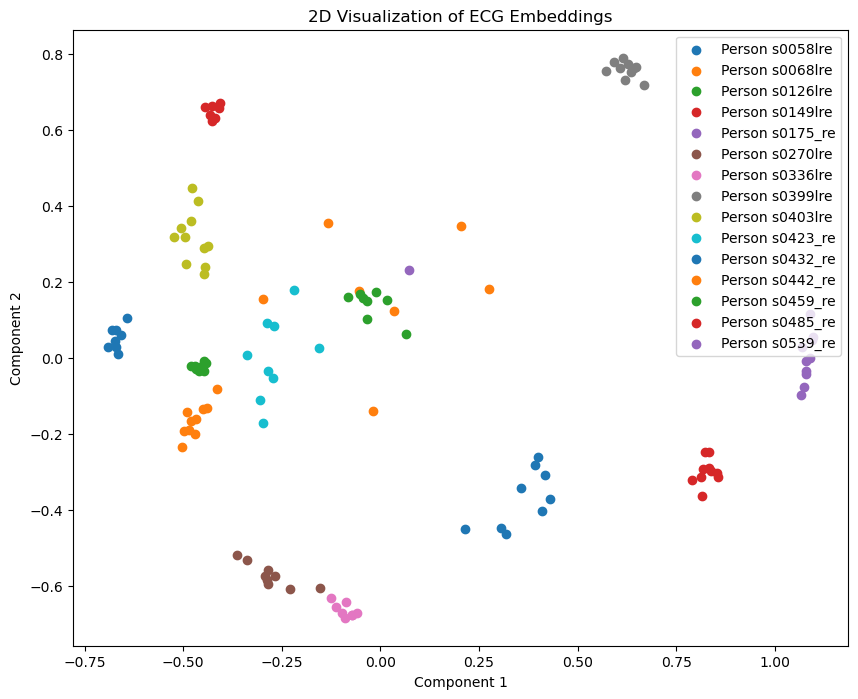

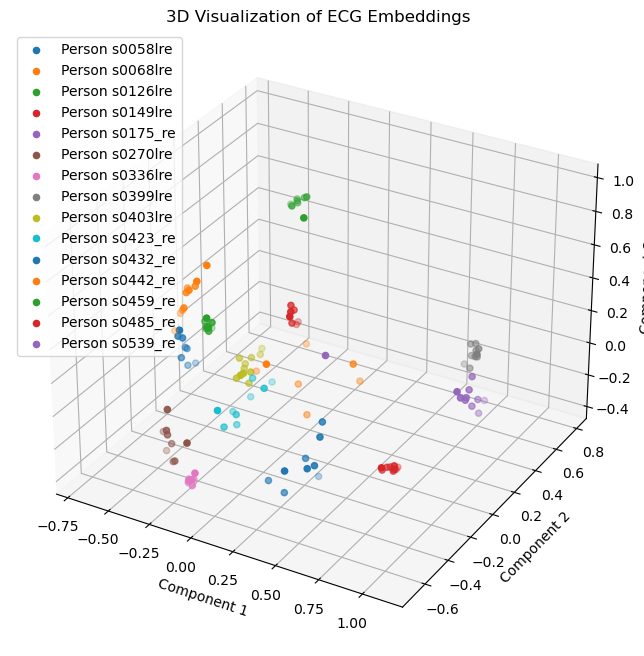

In [249]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Assume `embeddings` is the output from your model and `labels` are the true labels
silhouette_avg = silhouette_score(embeddings_train, ptb_y_train)
print(f"Silhouette Score: {silhouette_avg}")

# Load the saved embedding model
# embedding_model = arcface_facenet_model
unique_classes = np.random.choice(np.unique(ptb_y_train), 15, replace=False)

# Create a mask to select only those embeddings and labels corresponding to the 5 unique classes
mask = np.isin(ptb_y_train, unique_classes)

# Filter the embeddings and labels
filtered_embeddings_train = embeddings_train[mask]
filtered_ptb_y_train = ptb_y_train[mask]
# Generate embeddings for the test set
X_test_embeddings = filtered_embeddings_train
y_test_embeddings=filtered_ptb_y_train
# Use PCA or t-SNE for dimensionality reduction
def reduce_dimensionality(embeddings, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
        print(reducer)
    elif method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduce embeddings to 2D for visualization
try:
    reduced_embeddings_2d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=2)
except Exception as e:
    print(f"Error during dimensionality reduction: {e}")

# Ensure y_test is a numpy array and has the same length as reduced_embeddings_2d
# y_test = np.array(y_test[:60])

# Plot the 2D vector space
plt.figure(figsize=(10, 8))
try:
    for label in np.unique(y_test_embeddings):
        indices = np.where(y_test_embeddings == label)
        plt.scatter(reduced_embeddings_2d[indices, 0], reduced_embeddings_2d[indices, 1], label=f'Person {label}')
    plt.title('2D Visualization of ECG Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Reduce embeddings to 3D for visualization
try:
    reduced_embeddings_3d = reduce_dimensionality(X_test_embeddings, method='pca', n_components=3)
except Exception as e:
    print(f"Error during dimensionality reduction to 3D: {e}")

# Plot the 3D vector space
fig = plt.figure(figsize=(10, 8))
try:
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_test_embeddings):
        indices = np.where(y_test_embeddings == label)
        ax.scatter(reduced_embeddings_3d[indices, 0], reduced_embeddings_3d[indices, 1], reduced_embeddings_3d[indices, 2], label=f'Person {label}')
    ax.set_title('3D Visualization of ECG Embeddings')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error during 3D plotting: {e}")


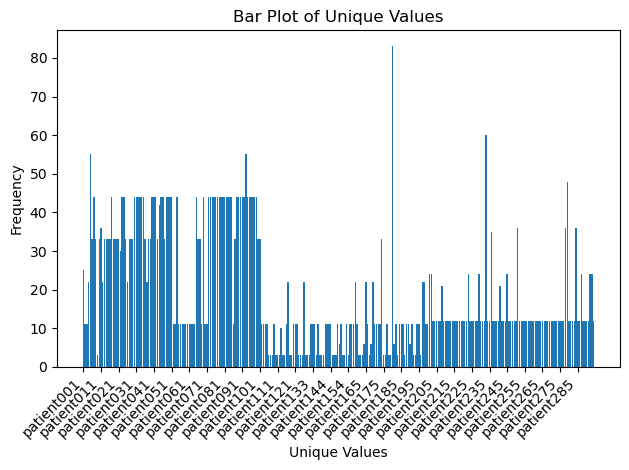

19.73793103448276


In [335]:
unique, frequency = np.unique(y,
                              return_counts = True) 
# print(unique)

plt.bar(unique, frequency)
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Bar Plot of Unique Values')
# plt.show()
n = 10
plt.xticks(ticks=unique[::n], labels=unique[::n], rotation=45, ha='right')
# Add padding to avoid label cutoff
plt.tight_layout()

plt.show()
print(sum(frequency)/len(frequency))

In [329]:
print("no of unique persons",len(np.unique(ptb_y_train)))

no of unique persons 290


In [191]:
print("no of training samples for KNN ",ptb_y_train.shape)

no of training samples for KNN  (4579,)


In [192]:
ptb_y_train

array(['s0082lre', 's0466_re', 's0247lre', ..., 's0499_re', 's0527_re',
       's0093lre'], dtype='<U8')